In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from Project_Gas_Library import f_EIA_ListSeries, f_EIA_ExtractData, f_PlotData, f_EIA_PlotData, f_EIA_PlotData_Mod,\
f_WorldWeather_ExtractData, f_PlotData, f_Census_ExtractData, calculate_color, f_strToDate, f_EIA_ExtractData_Range, \
f_EIA_PlotData_Range, f_EIA_PlotData_Mod_Range, f_EIA_PlotData_Stack_Range

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA

#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange

from config import worldweather_key, g_key, EIA_key, census_key

from matplotlib.pyplot import cm
from citipy import citipy
from pprint import pprint

from matplotlib.cm import viridis
from matplotlib.colors import to_hex

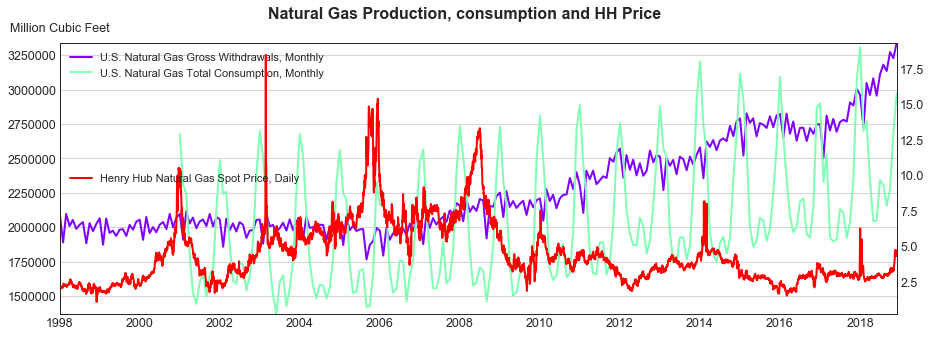

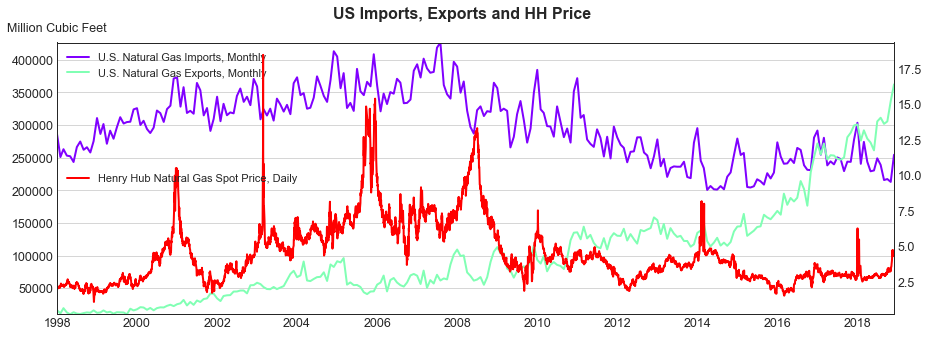

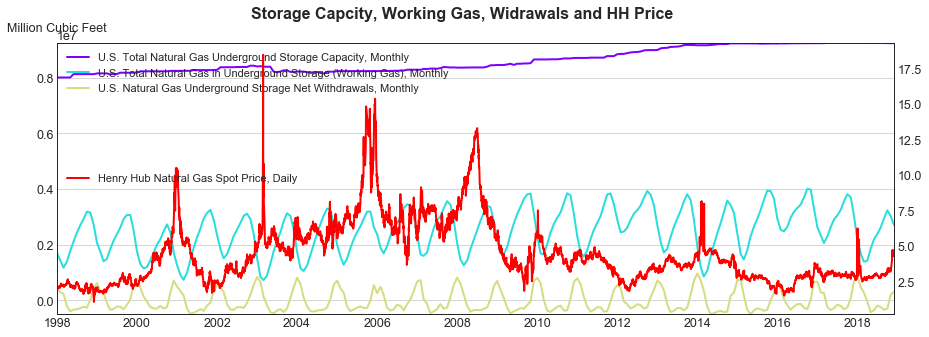

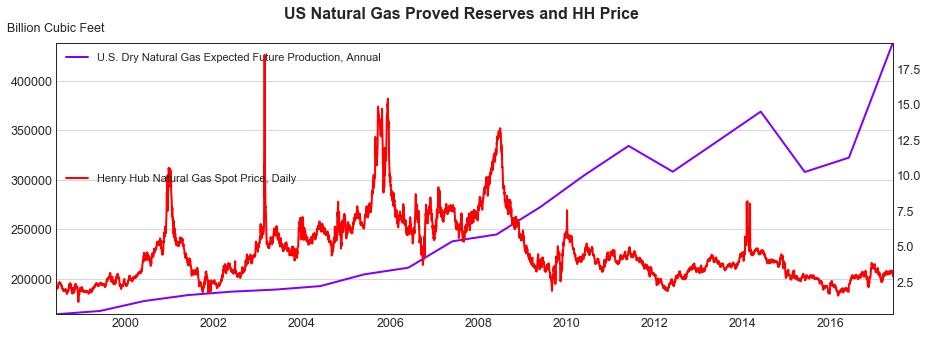

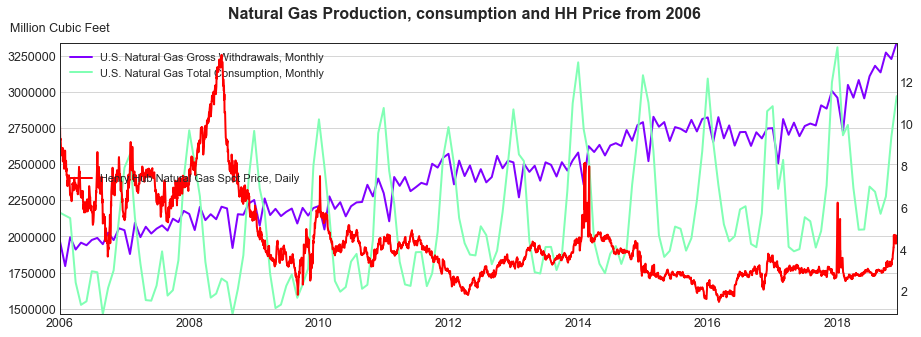

In [2]:
#Defining variables to extract data from EIA
eia_api_key = EIA_key
url = "http://api.eia.gov/series/"

Price_series_id =["NG.RNGWHHD.D"] # HH Prices
Volume_series_id = ["NG.N9010US2.M","NG.N9140US2.M"] # Total Widrawals Consumption

ImpEx_series_id = [ "NG.N9100US2.M", "NG.N9130US2.M"] # Import and Exports

Storage_series_id = ["NG.N5290US2.M","NG.N5020US2.M","NG.N5070US2.M"]
#Capacity, working gas, witdrawals

Reserves_series_id = ["NG.RNGR11NUS_1.A"]

ini_date = "1998-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Imports, Exports and HH Price"
f_EIA_PlotData_Mod_Range(ImpEx_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "Storage Capcity, Working Gas, Widrawals and HH Price"
f_EIA_PlotData_Mod_Range(Storage_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Natural Gas Proved Reserves and HH Price"
f_EIA_PlotData_Mod_Range(Reserves_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

ini_date = "2006-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price from 2006"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

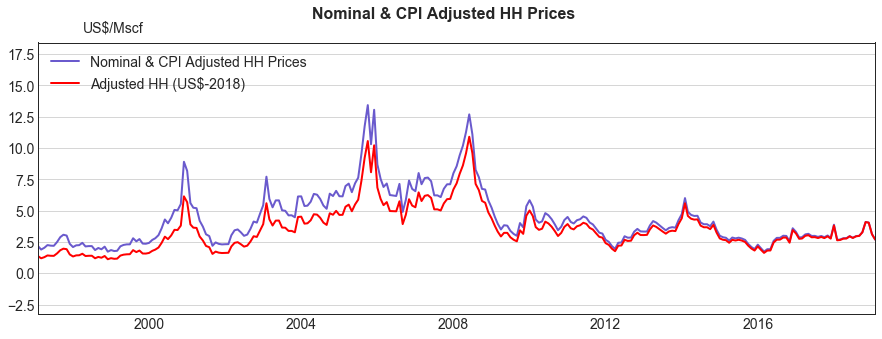

In [3]:
series_id_price = "NG.RNGWHHD.D" #HH

lx_hh_d, ly_hh_d, title_hh_d, country_hh_d, unit_hh_d = f_EIA_ExtractData(url,eia_api_key,series_id_price)
#convert output to a dictionary
d_hh = {
    "Date": lx_hh_d,
    "HH Price":ly_hh_d
}

#convert the dictionary to a dataframe 
df_hh = pd.DataFrame(d_hh)
# making the date column a panda date variable
df_hh["Date"]= pd.to_datetime(df_hh['Date'])

#convert the daily data to monthly data (Aggregation helps to reduce volatility !!!!!!!!)
df_hh = df_hh.set_index('Date')
df_hh_m = df_hh.resample('MS').mean()
df_hh_m.reset_index(inplace=True)

# converting panda date type to object
for index, row in df_hh_m.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_hh_m.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_hh_m['Date']
df_hh_m = df_hh_m.rename(columns={'Date_1': 'Date'})

#Obtaining the CPI values
file = "CPIAUCSL.csv"
df_cpi = pd.read_csv(file)
# making the date column a panda date variable
df_cpi["DATE"]= pd.to_datetime(df_cpi['DATE'])

df_cpi = df_cpi.rename(columns={'DATE': 'Date',"CPIAUCSL" :"CPI"})

# converting panda date type to object
for index, row in df_cpi.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_cpi.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_cpi['Date']
df_cpi = df_cpi.rename(columns={'Date_1': 'Date'})

#Creating a dataframe that storage info related to HH
df_HH = df_hh_m.merge(df_cpi,on="Date",how="inner")

# Correcting HH prices by inflation using CPI - the objective is to convert prices to US$ 2018
maxDate = df_HH["Date"].max()
updCPI = df_HH.loc[df_HH["Date"]==maxDate,"CPI"]
updCPI=min(updCPI)
df_HH["CPI-2018"] = df_HH["CPI"]*1/updCPI
df_HH["HH Price Upd"] = df_HH["HH Price"]*df_HH["CPI-2018"]

#Creating the log Prices columns
df_HH["Log HH Price"] = np.log(df_HH["HH Price"])
df_HH["Log HH Price Upd"] = np.log(df_HH["HH Price Upd"])

#Creating Columns with shift
df_HH["Log HH Price Upd Shift 1"] = df_HH["Log HH Price Upd"].shift()
df_HH["Log HH Price Shift 1"] = df_HH["Log HH Price"].shift()
df_HH=df_HH.dropna()

#Ploting HH and adjusted HH Prices
title = "Nominal & CPI Adjusted HH Prices"
unit = "US$/Mscf"
fig, ax = f_PlotData(df_HH["Date"],df_HH["HH Price"], title, unit)
ax.plot(df_HH["Date"],df_HH["HH Price Upd"], linewidth=2,color="red",label="Adjusted HH (US$-2018)")
ax.legend(loc='upper left')
plt.savefig(FileName)
FileName = "Figures-Presentation/" + title + ".png"
plt.show()

In [4]:
ini_date = "2006-1-1"; end_date = "2018-12-31"

series_id = Volume_series_id[0]
x_prod, y_prod, title_prod, country_prod, unit_prod = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[0]
x_imp, y_imp, title_imp, country_imp, unit_imp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[1]
x_exp, y_exp, title_exp, country_exp, unit_exp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#Capacity, working gas, witdrawals

series_id = Storage_series_id[0] #Capacity
x_stocap, y_stocap, title_stocap, country_stocap, unit_stocap = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#series_id = Storage_series_id[1]
#x_sto, y_sto, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[1] # Working Gas
x_wg, y_wg, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[2] # Widrawals
x_wit, y_wit, title_wit, country_wit, unit_wit = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Volume_series_id[1]
x_com, y_com, title_com, country_com, unit_com = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

y_price = []
for i in range(0,len(x_prod),1):
        HH_Price_Upd = min(df_HH.loc[df_HH["Date"]==x_prod[i],"HH Price Upd"])
        y_price.append(HH_Price_Upd)

dict_data = {
    "Price 2018 US$": y_price,
    "Production": y_prod,
    "Comsumption": y_com,
    "Storage Capacity": y_stocap,
    "Import": y_imp,
    "Export": y_exp
    #"Widrawals": y_wit,
    #"Working Gas": y_wg
}

df_data = pd.DataFrame(dict_data)

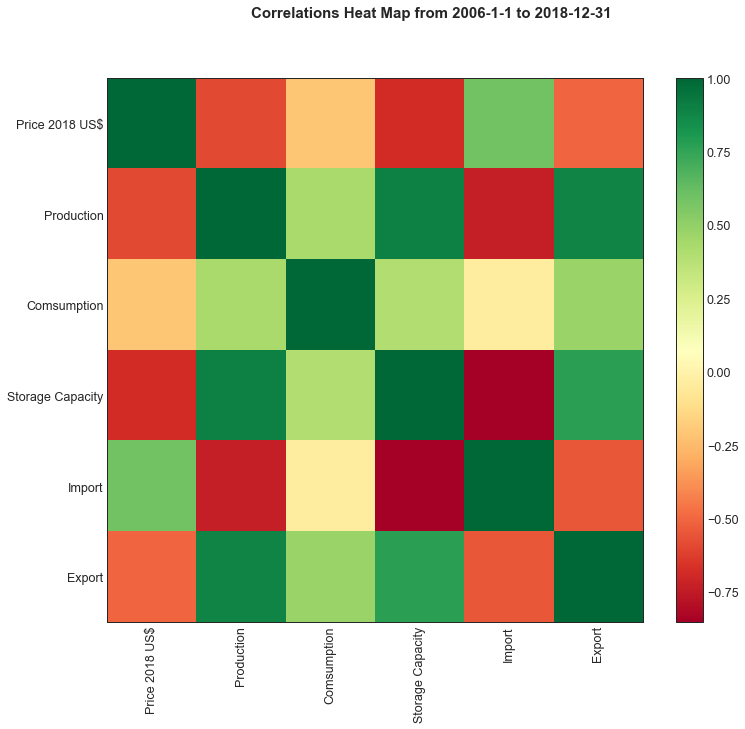

In [9]:
#Compute Correlation
corr = df_data.corr()

#Plot Correlation Matrix using Matplotlib
#%pylab inline
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
str_Title = 'Correlations Heat Map from ' + ini_date + ' to ' + end_date
plt.suptitle(str_Title, fontsize=15, fontweight='bold')
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

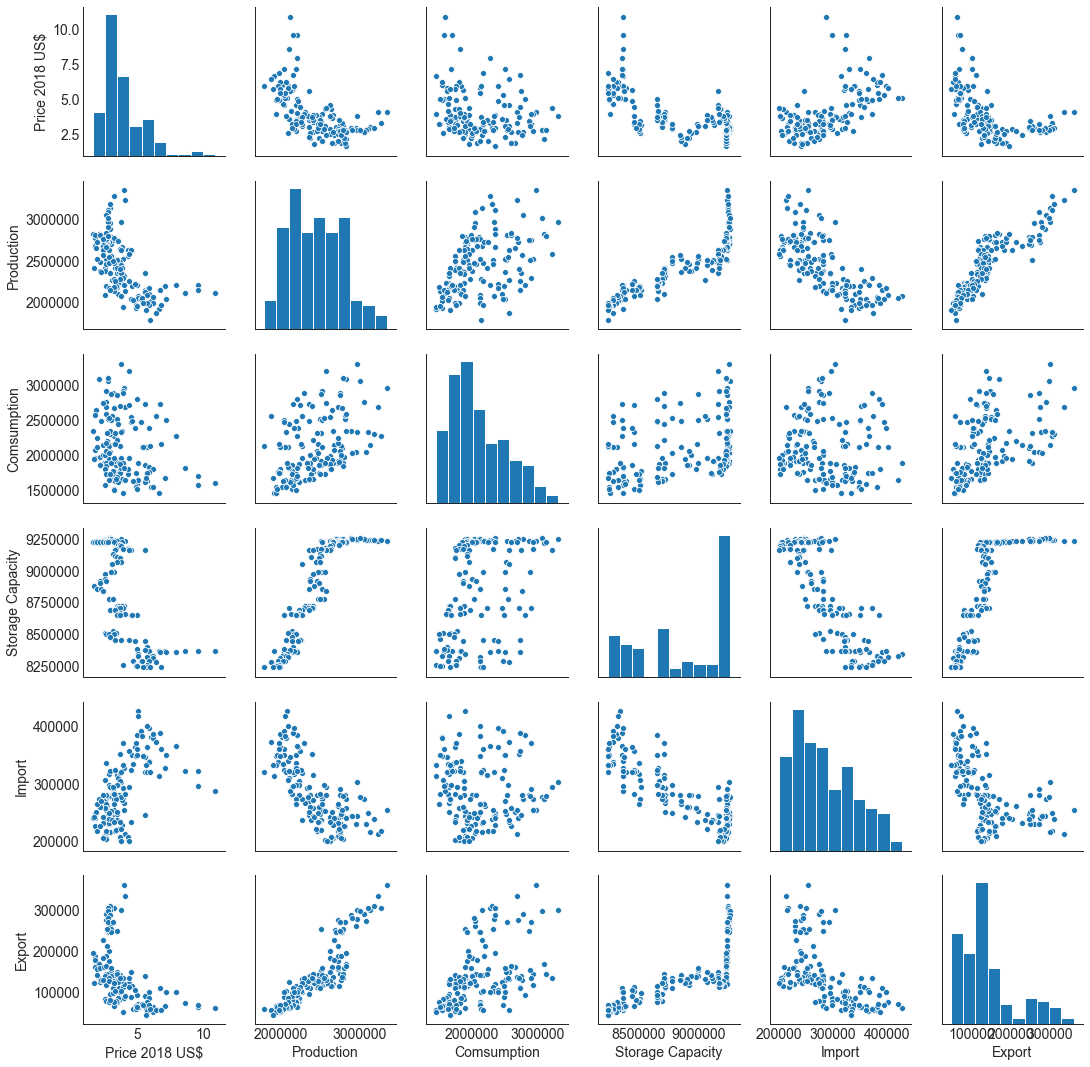

In [6]:
sns.pairplot(df_data)
str_Title = "Pairplot"
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

In [21]:
corr

,Price 2018 US$,Production,Comsumption,Storage Capacity,Import,Export
Price 2018 US$,1.000000,-0.590562,-0.201347,-0.678422,0.588656,-0.499387
Production,-0.590562,1.000000,0.430126,0.901519,-0.735379,0.887699
Comsumption,-0.201347,0.430126,1.000000,0.401012,-0.040518,0.476238
Storage Capacity,-0.678422,0.901519,0.401012,1.000000,-0.851897,0.770290
Import,0.588656,-0.735379,-0.040518,-0.851897,1.000000,-0.543388
Export,-0.499387,0.887699,0.476238,0.770290,-0.543388,1.000000


In [7]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Production","Comsumption","Storage Capacity","Import","Export"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
model.summary()

Production         -4.586727e-08
Comsumption        -3.082690e-07
Storage Capacity    1.023656e-07
Import              1.513425e-05
Export             -4.050563e-06
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Price 2018 US$   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     310.8
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           1.46e-77
Time:                        10:14:23   Log-Likelihood:                -255.41
No. Observations:                 156   AIC:                             520.8
Df Residuals:                     151   BIC:                             536.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Production       -4.587e-08   9.94e-07     -0.046      0.963   -2.01e-06    1.92e-06
Comsumption      -3.083e-07   2.92e-07     -1.056      0.293   -8.85e-07    2.68e-07
Storage Capacity  1.024e-07   2.78e-07      0.368      0.714   -4.48e-07    6.53e-07
Import            1.513e-05   2.32e-06      6.525      0.000    1.06e-05    1.97e-05
Export           -4.051e-06   3.15e-06     -1.284      0.201   -1.03e-05    2.18e-06
==============================================================================
Omnibus:                       82.166   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.962
Skew:                           1.953   Prob(JB):                     6.93e-84
Kurtosis:                       9.608   Cond. No.                         304.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

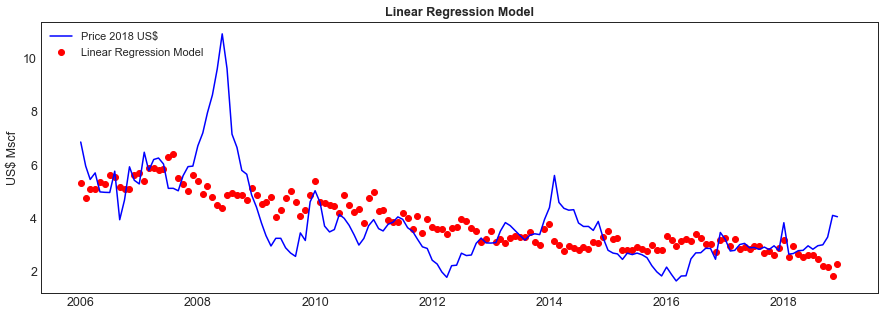

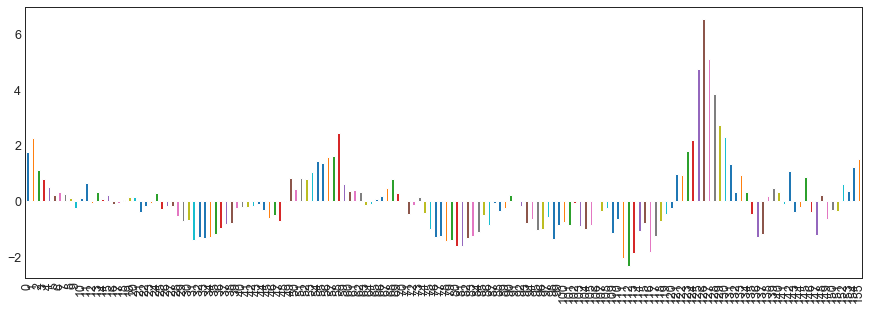

In [12]:
model_pred = model.predict()
x_prod

large = 16; med = 12.5; small = 11
params = {'axes.titlesize': med,
        'legend.fontsize': small,
        'figure.figsize': (15, 5),
        'axes.labelsize': med,
        'axes.titlesize': med,
        'xtick.labelsize': med,
        'ytick.labelsize': med,
        'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

plt.scatter(x_prod,model_pred,c="r",label="Linear Regression Model")
plt.plot(x_prod,df_data["Price 2018 US$"],c="b",label="Price 2018 US$")
plt.ylabel("US$ Mscf")
plt.legend(loc="upper left")

str_title = "Linear Regression Model"
plt.title(str_title, fontweight="bold")
FileName ="Figures-Presentation/" + str_title + ".png"
plt.savefig(FileName)

plt.show()


model.resid.plot(kind="bar")




In [16]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Production"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")
#model.summary()

Production    0.000001
dtype: float64
R2: 0.7841209203235798
p: Production    1.817365e-53
dtype: float64


In [17]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Comsumption"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
print(f"R2: {R2}")
print(f"p: {pp}")
#model.summary()

Comsumption    0.000002
dtype: float64
R2: 0.7935254805673693
p: Comsumption    5.724366e-55
dtype: float64


In [18]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Storage Capacity"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")
#model.summary()

Storage Capacity    4.304679e-07
dtype: float64
R2: 0.8323862028739588
p: Storage Capacity    5.362444e-62
dtype: float64


In [19]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Import"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")
#model.summary()

Import    0.000014
dtype: float64
R2: 0.9024905039110247
p: Import    3.014323e-80
dtype: float64


In [20]:
model = sm.OLS(df_data["Price 2018 US$"], df_data[["Export"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
print(f"R2: {R2}")
print(f"p: {pp}")
#model.summary()

Export    0.000019
dtype: float64
R2: 0.5385593219421763
p: Export    8.074179e-28
dtype: float64
